Model Performance:
Root Mean Squared Error (RMSE): 6.17
R² Score: 0.60

Predicted Unemployment Rate for Andhra Pradesh in November 2020: 6.01%


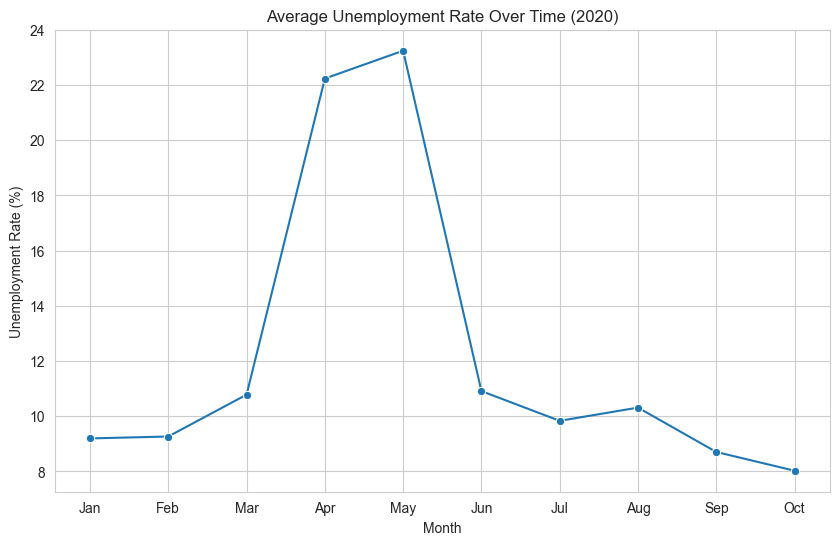

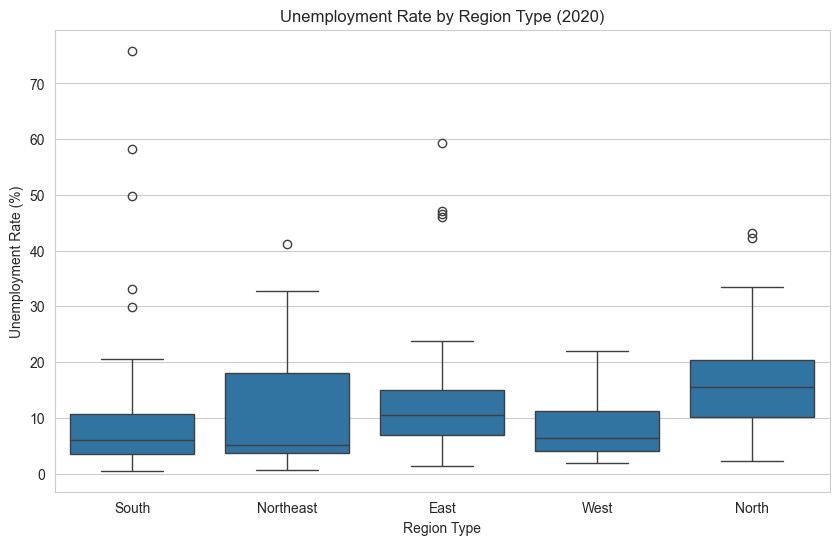

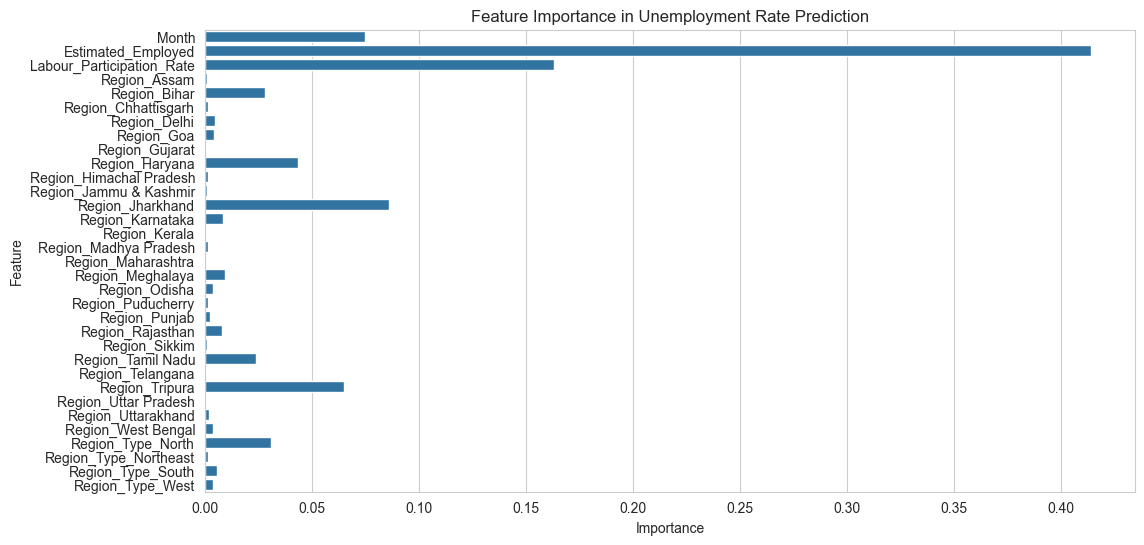

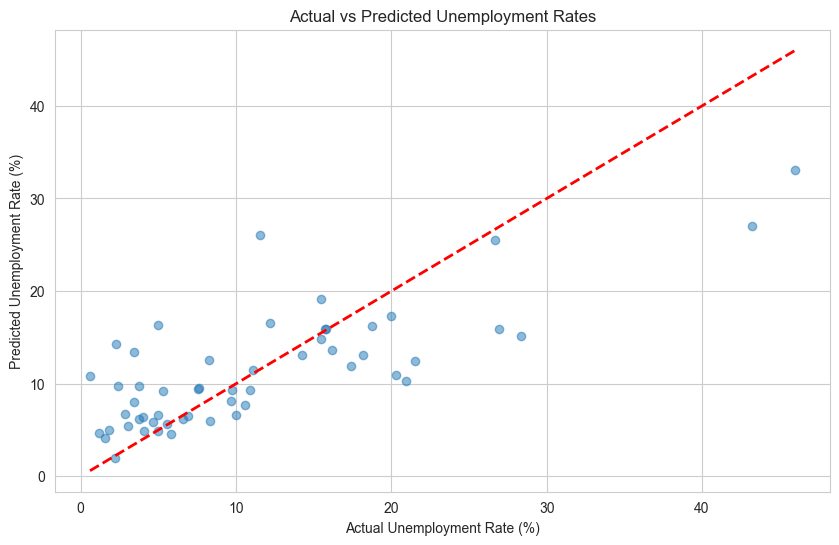

In [14]:
# unemployment_analysis.py

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv('unemprecovid.csv')

# Data Preprocessing
# Rename columns for clarity (removing spaces and special characters)
df.columns = ['Region', 'Date', 'Frequency', 'Unemployment_Rate', 'Estimated_Employed', 
              'Labour_Participation_Rate', 'Region_Type', 'Longitude', 'Latitude']

# Strip whitespace from Date column to fix formatting issues
df['Date'] = df['Date'].str.strip()

# Convert Date to datetime and extract month/year for analysis
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year

# Select features and target
features = ['Month', 'Region', 'Region_Type', 'Estimated_Employed', 'Labour_Participation_Rate']
target = 'Unemployment_Rate'

# Define numerical and categorical columns
numeric_features = ['Month', 'Estimated_Employed', 'Labour_Participation_Rate']
categorical_features = ['Region', 'Region_Type']

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)
    ])

# Create pipeline with preprocessor and Random Forest Regressor
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

# Split data into training and testing sets
X = df[features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"Model Performance:")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.2f}")

# Function to predict unemployment rate for a new input
def predict_unemployment_rate(region, region_type, month, estimated_employed, labour_participation_rate):
    input_data = pd.DataFrame({
        'Region': [region],
        'Region_Type': [region_type],
        'Month': [month],
        'Estimated_Employed': [estimated_employed],
        'Labour_Participation_Rate': [labour_participation_rate]
    })
    prediction = model.predict(input_data)[0]
    return prediction

# Example prediction
example_pred = predict_unemployment_rate(
    region='Andhra Pradesh',
    region_type='South',
    month=11,  # Predicting for November 2020
    estimated_employed=15000000,
    labour_participation_rate=37.5
)
print(f"\nPredicted Unemployment Rate for Andhra Pradesh in November 2020: {example_pred:.2f}%")

# Visualizations
# 1. Unemployment Rate Trend Over Time (Average across all regions)
plt.figure(figsize=(10, 6))
avg_unemployment = df.groupby('Month')['Unemployment_Rate'].mean().reset_index()
sns.lineplot(x='Month', y='Unemployment_Rate', data=avg_unemployment, marker='o')
plt.title('Average Unemployment Rate Over Time (2020)')
plt.xlabel('Month')
plt.ylabel('Unemployment Rate (%)')
plt.xticks(range(1, 11), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct'])
plt.grid(True)
plt.show()

# 2. Unemployment Rate by Region Type (Boxplot)
plt.figure(figsize=(10, 6))
sns.boxplot(x='Region_Type', y='Unemployment_Rate', data=df)
plt.title('Unemployment Rate by Region Type (2020)')
plt.xlabel('Region Type')
plt.ylabel('Unemployment Rate (%)')
plt.show()

# 3. Feature Importance (from Random Forest)
# Extract feature names after one-hot encoding
ohe = model.named_steps['preprocessor'].named_transformers_['cat']
ohe_feature_names = ohe.get_feature_names_out(categorical_features)
feature_names = numeric_features + ohe_feature_names.tolist()
feature_importances = model.named_steps['regressor'].feature_importances_

# Plot feature importance
plt.figure(figsize=(12, 6))
sns.barplot(x=feature_importances, y=feature_names)
plt.title('Feature Importance in Unemployment Rate Prediction')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# 4. Actual vs Predicted Unemployment Rates
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.title('Actual vs Predicted Unemployment Rates')
plt.xlabel('Actual Unemployment Rate (%)')
plt.ylabel('Predicted Unemployment Rate (%)')
plt.grid(True)
plt.show()